In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; }
.container {width:95% !important;}
</style>

<h1 style="text-align:center">Semana 9. Clase 8: Acústica en Python</h1>
<h3 style="text-align:center">ACUS220: Acústica computacional con Python</h3>
<p style="text-align:center">Dr. Víctor Poblete <br>
<a href="mailto:vpoblete@uach.cl">vpoblete@uach.cl</a><br>
<a href="https://github.com/vpobleteacustica/ACUS220-Acustica-Computacional-con-Python">https://github.com/vpobleteacustica/ACUS220-Acustica-Computacional-con-Python</a><br> 
<p style="text-align:center">Diego Espejo Alquinta - Ayudante <br>
<a href="mailto:diego.espejo@alumnos.uach.cl">diego.espejo@alumnos.uach.cl </a><br>
<a href="http://www.acusticauach.cl">www.acusticauach.cl</a><br> 

# Introducción

+ El método de integración hacia atrás de Schroeder es el método más utilizado para extraer la curva de caída de una respuesta de impulso acústico y calcular el tiempo de reverberación a partir de esta curva.
+ Ocuparemos este metodo para estimar los tiempos de reverberación de 3 salas, en particular, Aula Magna UACh, Catedral de Valdivia y Camara reverberante del Instituto de Acústica UACh, a partir de de las respuestas impulso obtenidas en cada una de ellas.  
+ Se espera que los estudiantes formulen un reporte en ambiente notebook, que respalde el código mediante los fundamentos acústicos relacionados.

[Apuntes Acústica arquitectonica.](https://www.dropbox.com/sh/xsvyk8rklar00ov/AADTGzrXSyUR0OJWW9swDgOia?dl=0)
        
        Si poseen una respuesta impulso de otra sala, entonces usarla para estimar su tiempo de reverberacion mediante este método.

In [2]:
import numpy as np
import librosa as lib
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.signal import lfilter,butter

In [3]:
signals = ['AulaMagna_Impulso','Catedral_Impulso','Reverberante']
df = pd.DataFrame()

In [4]:
l=0
for s in signals:
    sig ,fs = lib.load(s+'.wav',sr=44100)
    if len(sig)<l:
        cola = np.zeros((l-len(sig)))
        sig = np.concatenate((sig,cola))
    else:
        l=len(sig)
    df[s]=sig   

In [5]:
df

,AulaMagna_Impulso,Catedral_Impulso,Reverberante
0,-0.000031,-0.000061,-0.000122
1,0.000031,-0.000031,0.000244
2,0.000000,-0.000122,0.000305
3,0.000061,0.000061,-0.000031
4,-0.000031,-0.000153,0.000061
...,...,...,...
190459,0.000031,0.000000,0.000000
190460,0.000122,0.000000,0.000000
190461,0.000031,0.000000,0.000000
190462,0.000214,0.000000,0.000000


In [6]:
print(df[signals[0]])

0        -0.000031
1         0.000031
2         0.000000
3         0.000061
4        -0.000031
            ...   
190459    0.000031
190460    0.000122
190461    0.000031
190462    0.000214
190463   -0.000061
Name: AulaMagna_Impulso, Length: 190464, dtype: float32


In [7]:
print(df['AulaMagna_Impulso'])

0        -0.000031
1         0.000031
2         0.000000
3         0.000061
4        -0.000031
            ...   
190459    0.000031
190460    0.000122
190461    0.000031
190462    0.000214
190463   -0.000061
Name: AulaMagna_Impulso, Length: 190464, dtype: float32


In [8]:
po      = 2e-5
Low_Freq=125
T = 1/fs
Winlength = fs/Low_Freq
L=l-Winlength
t = np.linspace(1,L,int(L))*T   
Prms = np.zeros((len(signals),int(L)))
level = np.zeros((len(signals),int(L)))
for i in range(len(signals)):
    sig = df[signals[i]]
    Prms[i,:]=np.sqrt((1/l)*(sum(sig**2))) 
    Prms[i,:]=Prms[i,:]/max(Prms[i,:])
    level[i,:]=20*np.log10(Prms[i,:]/po)

\begin{align}
    P_{rms} = \sqrt{\frac{1}{l}\times\sum_{i=0}^{l-1}sig_{i}^{2}} \\
    \\
    P_{rms_{N}} = \frac{P_{rms}}{\max {P_{rms}}} \\
    \\
    L_{rms_{N}} = 20\times \log_{10}\left(\frac{P_{RMS_{N}}}{P_{0}}\right)
\end{align}

In [9]:
def octfilt(sig,fs,l,N=3):

    Fc=[125,250,500,1000,2000,4000]
    B=np.zeros((len(Fc),7))
    A=np.zeros((len(Fc),7))
    Y=np.zeros((len(Fc),l))
    for i in range(len(Fc)):
        B[i],A[i]=oct3dsgn(Fc[i],fs,N)
        Y[i]=lfilter(B[i],A[i],sig)

    return Y

def oct3dsgn(Fc,fs,N):

    if (Fc > 0.88*(fs/2)):
        raise ValueError('Design not posible. Check frecuencies.')
    
    f1=Fc/np.sqrt(2)
    f2=Fc*np.sqrt(2)
    Qr =Fc/(f2-f1)
    Qd = (np.pi/2/N)/(np.sin(np.pi/2/N))*Qr
    alpha =(1+np.sqrt(1+4*Qd**2))/2/Qd
    W1 = Fc/(fs/2)/alpha
    W2 = Fc/(fs/2)*alpha
    B,A = butter(N,[W1,W2],btype='band')
    return B,A 

In [10]:
Y1=octfilt(df[signals[0]].values,fs,l)
Y2=octfilt(df[signals[1]].values,fs,l)
Y3=octfilt(df[signals[2]].values,fs,l)

In [11]:
def RT_schroeder(h,fs,region=[-5,-35],method=1,delay_comp=0):

    h_len=len(h)

    if delay_comp==1:
        i = where_is_max(h)
        h[0:h_len-i]=h[i-1:h_len-1]
        h_len =len(h)
    
    ## Energy decay curve

    h_sq = h**2
    h_sq = h_sq[::-1]
    EDC = np.cumsum(h_sq)
    EDC = EDC[::-1]

    ### normalize

    EDC_norm = EDC/max(EDC)

    ## Estimate the reverberation time

    if method == 1: #least square fitting
        #first value of the EDC decaying 60 dB (e-6)
        EDC_log = 10*np.log10(EDC_norm)
        EDC_reg1 = find_first(EDC_log,region[0])
        EDC_reg2 = find_first(EDC_log,region[1])
        
        EDC_reg12 = EDC_log[EDC_reg1:EDC_reg2]
        x = np.linspace(1,len(EDC_reg12),len(EDC_reg12))

        p = np.polyfit(x,EDC_reg12,deg=1)

        y = p[0]*x+p[1]
        y0 = y[0]-p[0]*EDC_reg1

        #intersection of polifit line with -60 dB
        x_rt = (-60-y0)/p[0]

        RT = x_rt/fs #reverberation time in [s]

        # fitting line from 0 to -60dB

        x = np.linspace(1,x_rt,int(x_rt))
        y = p[0]*x+y0
        
        return RT , p[0], y0
    
def RT_decay(RT,p0,y0,fs=44100):
    x_rt=RT*fs #reverberation time in [s]

    # fitting line from 0 to -60dB

    x = np.linspace(1,x_rt,int(x_rt))
    y = p0*x+y0
    return x,y
    

def where_is_max(h):
    for i in range(len(h)):
        if h[i]==max(h):
            return i

def find_first(vec,value):

    mask = [vec <= value]
    for i in range(len(mask[0])):
        if mask[0][i]:
            return i 

In [12]:
region=[-5,-15]
method=1
delay_comp=0

RT1 = np.zeros(Y1.shape[0])
RT2 = np.zeros(Y2.shape[0])
RT3 = np.zeros(Y3.shape[0])
p01  = np.zeros(Y1.shape[0])
y01  = np.zeros(Y1.shape[0])
p02  = np.zeros(Y1.shape[0])
y02  = np.zeros(Y1.shape[0])
p03  = np.zeros(Y1.shape[0])
y03  = np.zeros(Y1.shape[0])
# Y1 = aula magna
# Y2 = catedral
# Y3 = reverberante
for i in range(Y1.shape[0]):
    RT1[i],p01[i],y01[i]= RT_schroeder(Y1[i],fs,region,method,delay_comp)
    RT2[i],p02[i],y02[i]= RT_schroeder(Y2[i],fs,region,method,delay_comp)
    RT3[i],p03[i],y03[i]= RT_schroeder(Y3[i],fs,region,method,delay_comp)

/Users/Nigglea/miniconda3/envs/ayudantia/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


In [14]:
x_RTdecay1 = np.zeros((int(max(RT1)*fs),Y1.shape[0]))
x_RTdecay2 = np.zeros((int(max(RT2)*fs),Y2.shape[0]))
x_RTdecay3 = np.zeros((int(max(RT3)*fs),Y3.shape[0]))
y_RTdecay1 = np.zeros((int(max(RT1)*fs),Y1.shape[0]))
y_RTdecay2 = np.zeros((int(max(RT2)*fs),Y2.shape[0]))
y_RTdecay3 = np.zeros((int(max(RT3)*fs),Y3.shape[0]))
for i in range(Y1.shape[0]):
    x1,y1=RT_decay(RT1[i],p01[i],y01[i])
    if len(x1) <len(x_RTdecay1[:,i]):
        lx1 = np.zeros(len(x_RTdecay1[:,i])-len(x1))
        x1 = np.concatenate((x1,lx1))
        x_RTdecay1[:,i] = x1
    if len(x1) == len(x_RTdecay1[:,i]):
        x_RTdecay1[:,i] = x1
    if len(y1) <len(y_RTdecay1[:,i]):
        ly1 = np.zeros(len(y_RTdecay1[:,i])-len(y1))
        y1 = np.concatenate((y1,ly1))
        y_RTdecay1[:,i] = y1
    if len(y1) == len(x_RTdecay1[:,i]):
        y_RTdecay1[:,i] = y1
    x2,y2=RT_decay(RT2[i],p02[i],y02[i])
    if len(x2) <len(x_RTdecay2[:,i]):
        lx2 = np.zeros(len(x_RTdecay2[:,i])-len(x2))
        x2 = np.concatenate((x2,lx2))
        x_RTdecay2[:,i] = x2
    if len(x2) == len(x_RTdecay2[:,i]):
        x_RTdecay2[:,i] = x2
    if len(y2) <len(y_RTdecay2[:,i]):
        ly2 = np.zeros(len(y_RTdecay2[:,i])-len(y2))
        y2 = np.concatenate((y2,ly2))
        y_RTdecay2[:,i] = y2
    if len(y2) == len(y_RTdecay2[:,i]):
        y_RTdecay2[:,i] = y2
    x3,y3=RT_decay(RT3[i],p03[i],y03[i])
    if len(x3) <len(x_RTdecay3[:,i]):
        lx3 = np.zeros(len(x_RTdecay3[:,i])-len(x3))
        x3 = np.concatenate((x3,lx3))
        x_RTdecay3[:,i] = x3
    if len(x3) == len(x_RTdecay3[:,i]):
        x_RTdecay3[:,i] = x3
    if len(y3) <len(y_RTdecay3[:,i]):
        ly3 = np.zeros(len(y_RTdecay3[:,i])-len(y3))
        y3 = np.concatenate((y3,ly3))
        y_RTdecay3[:,i] = y3
    if len(y3) == len(y_RTdecay3[:,i]):
        y_RTdecay3[:,i] = y3

In [15]:
freq_idx=[125,250,500,1000,2000,4000]
RT = pd.DataFrame(index=freq_idx)
RT.index.name='Hz'
RT[signals[0]+' [seg]']=RT1
RT[signals[1]+' [seg]']=RT2
RT[signals[2]+' [seg]']=RT3
RT

,AulaMagna_Impulso [seg],Catedral_Impulso [seg],Reverberante [seg]
Hz,,,
125,1.571509,3.486421,9.851185
250,1.447979,3.726375,10.581780
500,1.323515,4.050720,10.356604
1000,1.188675,3.786827,8.546247
2000,1.174216,2.992281,5.752388
4000,1.204199,2.018436,4.064450


<IPython.core.display.Javascript object>


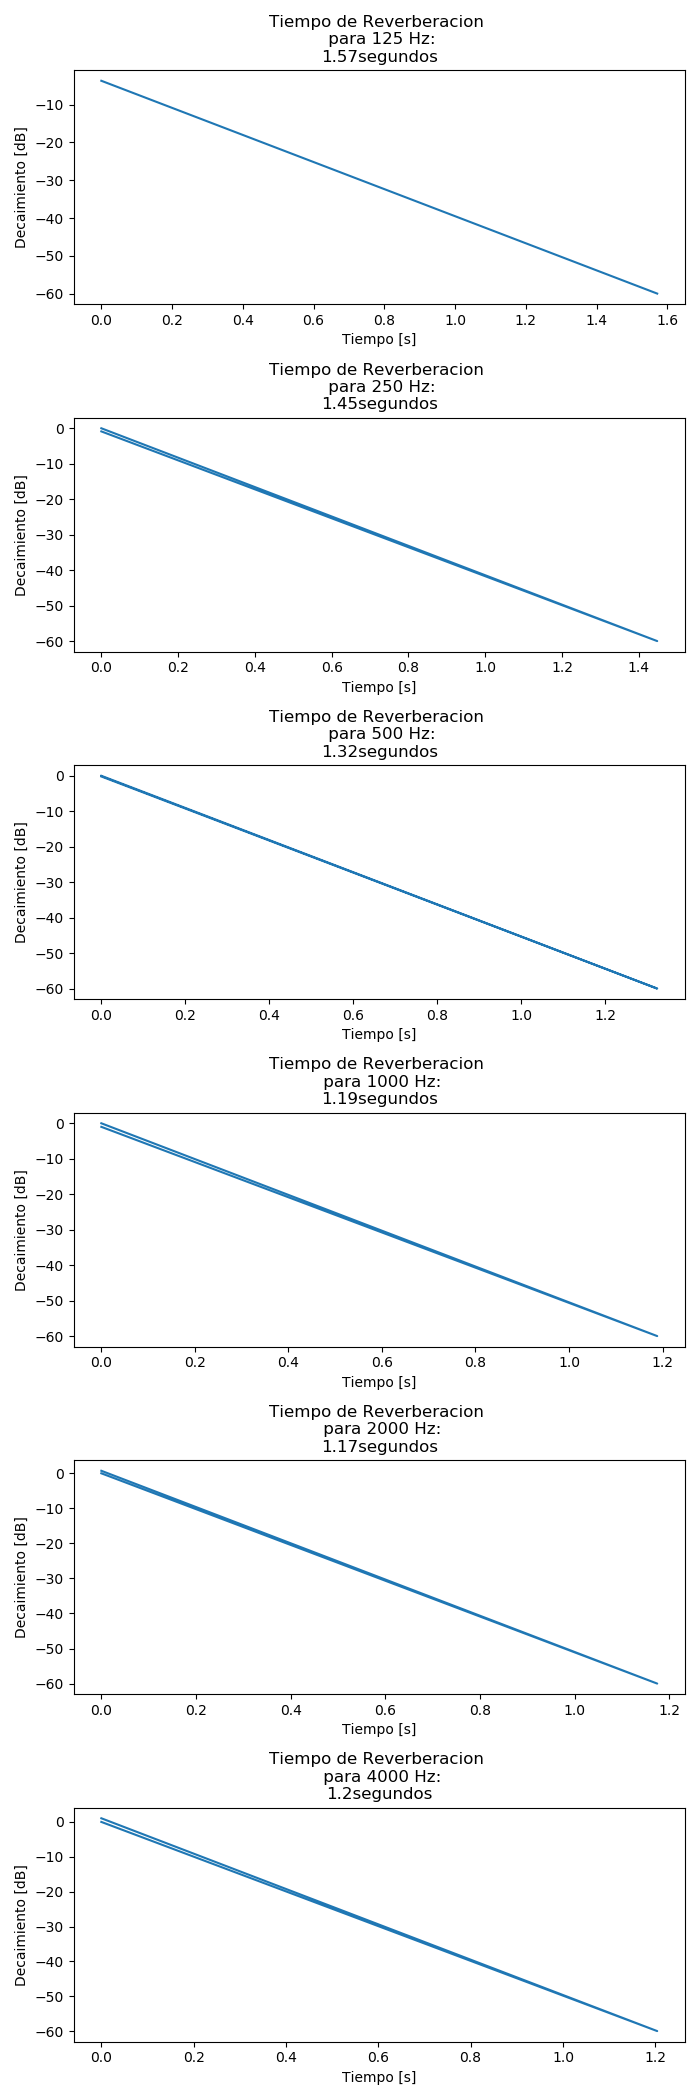

In [37]:
figRT, axRT = plt.subplots(Y1.shape[0],figsize=(7,21),tight_layout=True)

for i in range(Y1.shape[0]):
    axRT[i].plot(x_RTdecay1[:,i]/fs,y_RTdecay1[:,i])
    axRT[i].set_title(('Tiempo de Reverberacion \n para '+str(freq_idx[i])+' Hz:\n'+str(np.around(RT1[i],2))+'segundos')) 
    axRT[i].set_xlabel('Tiempo [s]')
    axRT[i].set_ylabel('Decaimiento [dB]')

<IPython.core.display.Javascript object>


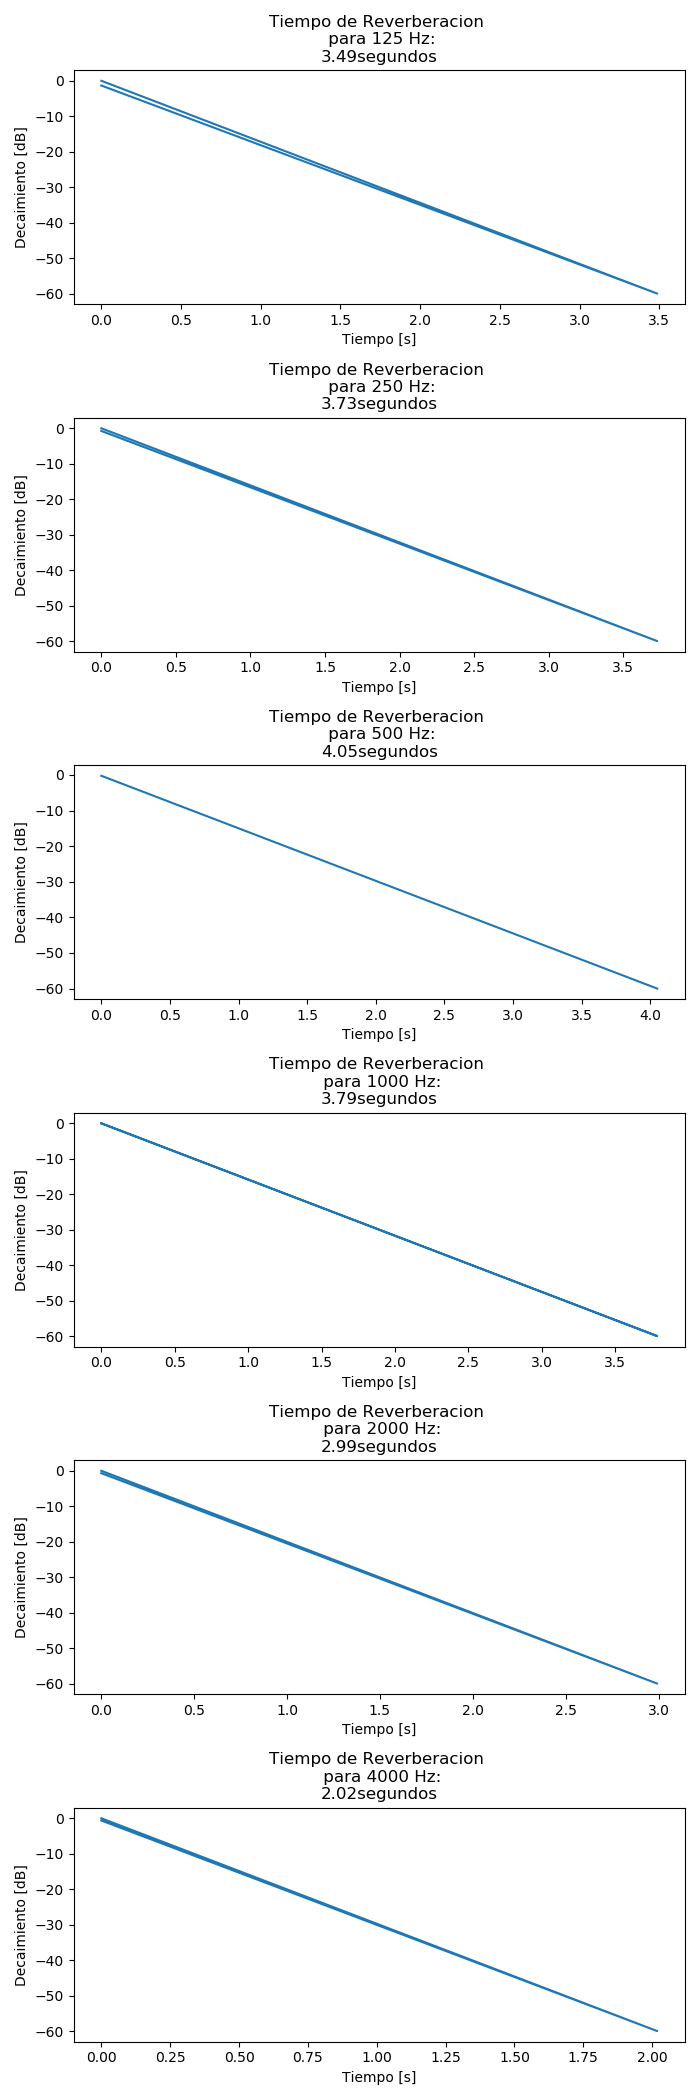

In [35]:
figRT1, axRT1 = plt.subplots(Y1.shape[0],figsize=(7,21),tight_layout=True)
for i in range(Y1.shape[0]):
    axRT1[i].plot(x_RTdecay2[:,i]/fs,y_RTdecay2[:,i])
    axRT1[i].set_title(('Tiempo de Reverberacion \n para '+str(freq_idx[i])+' Hz:\n'+str(np.around(RT2[i],2))+'segundos'))
    axRT1[i].set_xlabel('Tiempo [s]')
    axRT1[i].set_ylabel('Decaimiento [dB]')

<IPython.core.display.Javascript object>


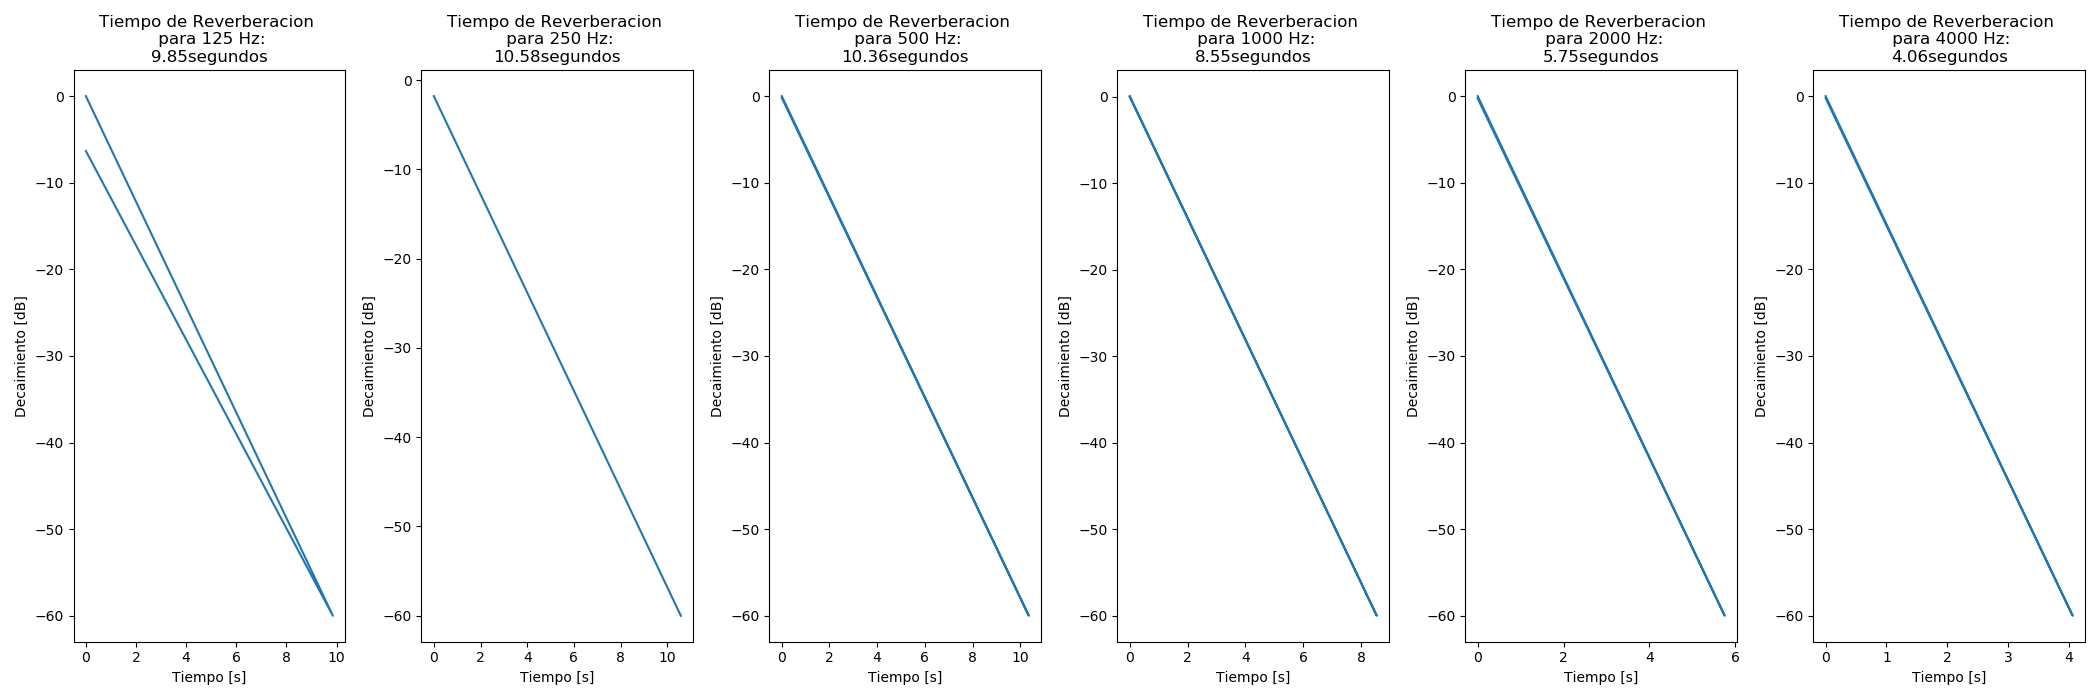

In [28]:
figRT2, axRT2 = plt.subplots(Y1.shape[0],figsize=(7,21),tight_layout=True)
for i in range(Y1.shape[0]):
    axRT2[i].plot(x_RTdecay3[:,i]/fs,y_RTdecay3[:,i])
    axRT2[i].set_title(('Tiempo de Reverberacion \n para '+str(freq_idx[i])+' Hz:\n'+str(np.around(RT3[i],2))+'segundos'))
    axRT2[i].set_xlabel('Tiempo [s]')
    axRT2[i].set_ylabel('Decaimiento [dB]')